In [1]:
import os 
import torch  
import torch.nn as nn 
import torch.nn.functional as F 
import torchvision 
import numpy as np
import matplotlib.pyplot as plt 
import cv2
# from torchvision import transforms
import torchvision.transforms as T
from modules import fpn 
from PIL import Image 
import random
from glob import glob


import seaborn as sns
from torchvision.models.feature_extraction import get_graph_node_names
from torchvision.models.feature_extraction import create_feature_extractor
from sklearn.manifold import TSNE
from torchvision.utils import _log_api_usage_once

In [2]:
def compute_dist(featmap, metric_function, euclidean_train=True):
    # centroids = metric_function.module.weight.data
    centroids = metric_function.weight.data
    if euclidean_train:
        return - (1 - 2*metric_function(featmap)\
                    + (centroids*centroids).sum(dim=1).unsqueeze(0)) # negative l2 squared 
    else:
        return metric_function(featmap)

In [3]:
class Arguments:
    def __init__(self, 
                data_root='../../Data/coco',
                supervised_data_root = '../../Data/coco_supervisedset',
                save_root='results',
                restart_path='',
                seed=1,
                num_workers=6,
                restart=True,
                num_epoch=20,
                repeats=1,
                arch='resnet18',
                pretrain=True,
                res=320,
                res1=320,
                res2=640,
                batch_size_cluster=4,
                batch_size_train=32,
                batch_size_test=8,
                lr=1e-4,
                weight_decay=0,
                momentum=0.9,
                optim_type='Adam',
                num_init_batches=3,
                num_batches=3,
                kmeans_n_iter=30,
                in_dim=128,
                X=80,
                metric_train='cosine',
                metric_test='cosine',
                K_train=27,
                K_test=27,
                no_balance=False,
                mse=False,
                augment=False,
                equiv=False,
                min_scale=0.5,
                stuff=True,
                thing=True,
                jitter=False,
                grey=False,
                blur=False,
                h_flip=False,
                v_flip=False,
                random_crop=False,
                val_type='train',
                version=7,
                fullcoco=False,
                eval_only=False,
                eval_path='results',
                save_model_path='K_train',
                save_eval_path='K_test',
                cityscapes=False,
                faiss_gpu_id=1
                ):

        self.data_root=data_root
        self.supervised_data_root=supervised_data_root
        self.save_root=save_root
        self.restart_path=restart_path
        self.seed=seed
        self.num_workers=num_workers
        self.restart=restart
        self.num_epoch=num_epoch
        self.repeats=repeats
        self.arch=arch
        self.pretrain=pretrain
        self.res=res
        self.res1=res1
        self.res2=res2
        self.batch_size_cluster=batch_size_cluster
        self.batch_size_train=batch_size_train
        self.batch_size_test=batch_size_test
        self.lr=lr
        self.weight_decay=weight_decay
        self.momentum=momentum
        self.optim_type=optim_type
        self.num_init_batches=num_init_batches
        self.num_batches=num_batches
        self.kmeans_n_iter=kmeans_n_iter
        self.in_dim=in_dim
        self.X=X
        self.metric_train=metric_train
        self.metric_test=metric_test
        self.K_train=K_train
        self.K_test=K_test
        self.no_balance=no_balance
        self.mse=mse
        self.augment=augment
        self.equiv=equiv
        self.min_scale=min_scale
        self.stuff=stuff
        self.thing=thing
        self.jitter=jitter
        self.grey=grey
        self.blur=blur
        self.h_flip=h_flip
        self.v_flip=v_flip
        self.random_crop=random_crop
        self.val_type=val_type
        self.cityscapes = cityscapes
        self.version=version
        self.fullcoco=fullcoco
        self.eval_only=eval_only
        self.eval_path=eval_path
        self.save_eval_path = save_eval_path
        self.save_model_path = save_model_path
        self.faiss_gpu_id = faiss_gpu_id
        
args = Arguments()

In [4]:
picie_load = torch.load('K_train/checkpoint_40.pth.tar', 'cpu')
model_state_dict = {}
classifier_state_dict = {}

for i in picie_load['state_dict'].keys():
    model_state_dict[i[7:]] = picie_load['state_dict'][i]


for i in picie_load['classifier1_state_dict'].keys():
    classifier_state_dict[i[7:]] = picie_load['classifier1_state_dict'][i]


In [5]:
picie_load = torch.load('K_train/checkpoint_40.pth.tar', 'cpu')

model = fpn.PanopticFPN(args)
# model = nn.DataParallel(model) 
model.load_state_dict(model_state_dict)

classifier = nn.Conv2d(args.in_dim, 27, kernel_size=1, stride=1, padding=0, bias=True)
# classifier = nn.DataParallel(classifier)
classifier.load_state_dict(classifier_state_dict)

# Important ! ""
model.eval()
classifier.eval()
model.cuda()
classifier.cuda()

Conv2d(128, 27, kernel_size=(1, 1), stride=(1, 1))

In [6]:
to_T = T.ToTensor()
test_set_path = "../../Data/coco_testset/images/*jpg"
transforms = torch.nn.Sequential(
    # T.ToTensor(),
    T.Resize(size=(320,320)),
    T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
)
imgs = []
inps = []
for file_path in glob(test_set_path):
    img = Image.open(file_path)
    img_ = transforms(to_T(img))
    inps.append(img_)
    imgs.append(img)

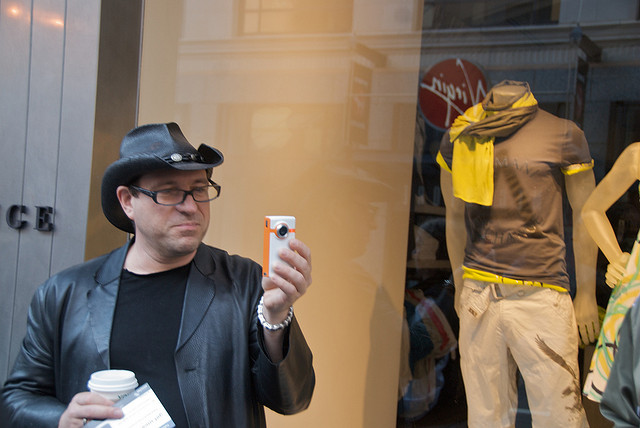

In [57]:
imgs[16]

In [7]:
inps[0].shape

torch.Size([3, 320, 320])

In [8]:
train_nodes, eval_nodes = get_graph_node_names(model)

assert([t == e for t, e in zip(train_nodes, eval_nodes)])

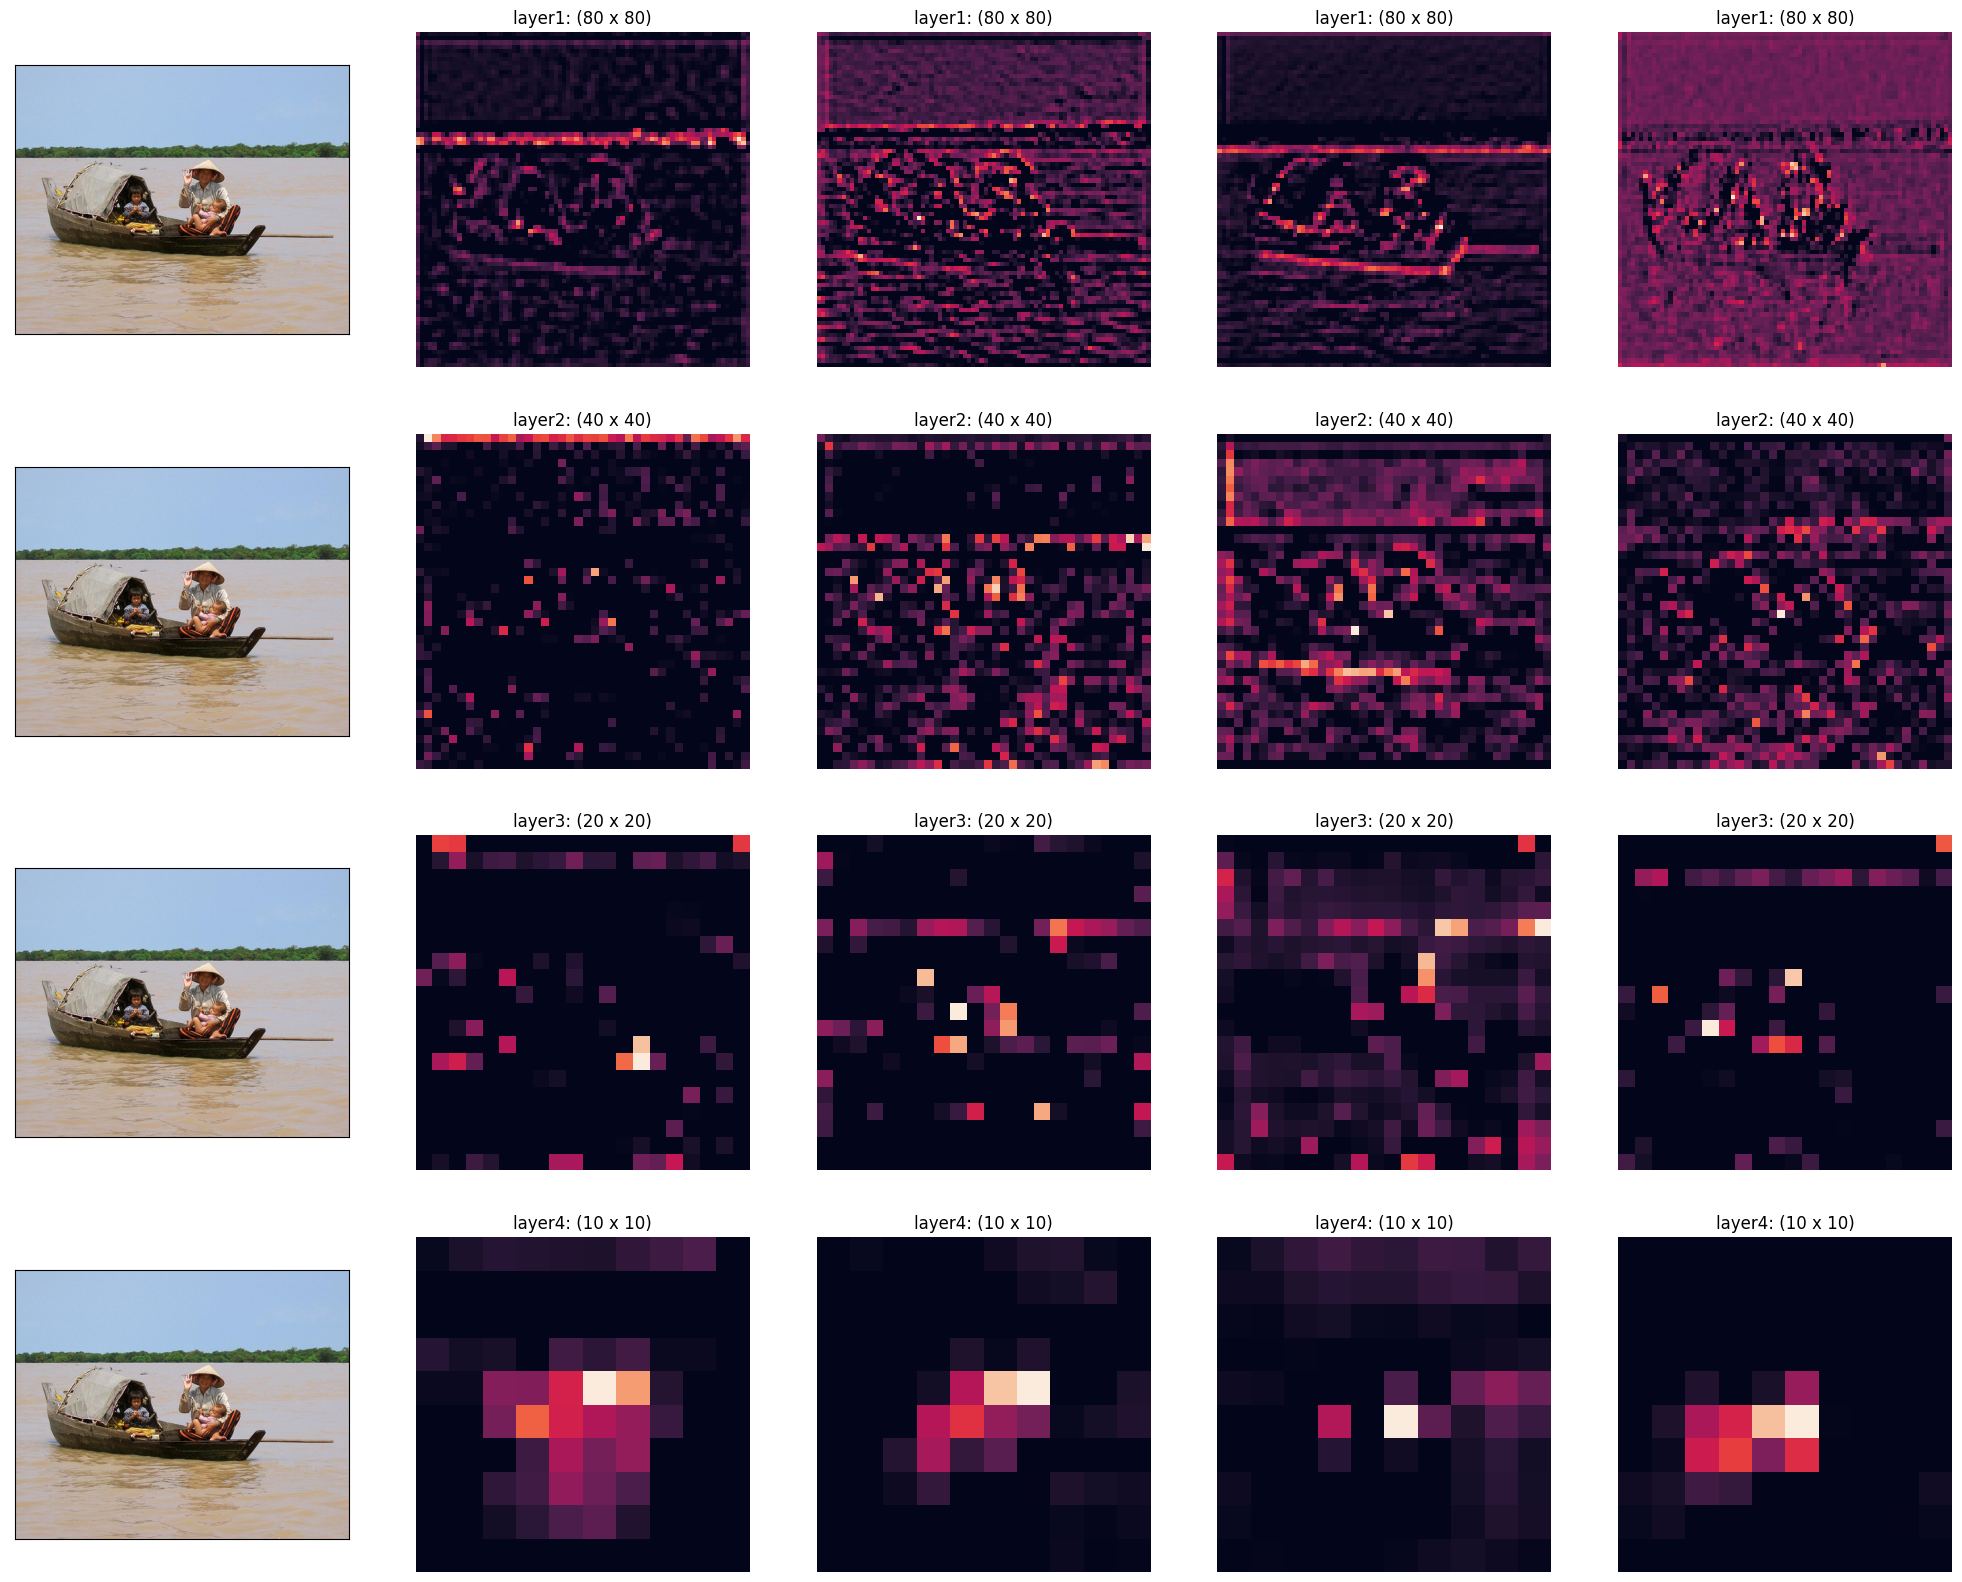

In [59]:
im_index = 0
return_nodes = ['layer1', 'layer2', 'layer3', 'layer4']

feat_ext = create_feature_extractor(model.backbone, return_nodes=return_nodes)

with torch.no_grad():
    out = feat_ext(inps[im_index].unsqueeze(dim=0).cuda())

fig, ax = plt.subplots(4, 5, figsize=(25, 20))

# Pick 4 random feature maps from each layer
for i, layer in enumerate(return_nodes):
    feat_maps = out[layer].cpu().numpy().squeeze(0)
    feat_maps = random.sample(list(feat_maps), 4)
    ax[i][0].imshow(imgs[im_index])
    ax[i][0].set_xticks([])
    ax[i][0].set_yticks([])
    for j, feat_map in enumerate(feat_maps):
        sns.heatmap(feat_map, ax=ax[i][j+1], cbar=False)
        ax[i][j+1].set_xticks([])
        ax[i][j+1].set_yticks([])
        ax[i][j+1].set_title(f'{layer}: ({feat_map.shape[0]} x {feat_map.shape[1]})')

In [111]:
imgs[10].filename

'../../Data/coco_testset/images/000000001840.jpg'

In [8]:
batch = torch.stack([i for i in inps]) 
batch.shape

torch.Size([118, 3, 320, 320])

In [11]:
# outputs = model(inps[10].unsqueeze(dim=0).cuda())
outputs = model(batch.cuda())
outputs.shape

torch.Size([118, 128, 80, 80])

In [10]:
outputs = classifier(outputs)
outputs.shape

torch.Size([118, 27, 80, 80])

In [12]:
labels = []
for output in outputs:
    out1 = F.normalize(output, dim=1, p=2)
    prb1 = compute_dist(out1, classifier)
    lbl1 = prb1.topk(1, dim=1)[1]
    lbl1 = lbl1.squeeze(0).squeeze(0)
    labels.append(lbl1.cpu().numpy())
labels = np.array(labels)

In [13]:
labels.shape

(118, 80, 80)

In [23]:
Y = torch.flatten(torch.tensor(labels), start_dim=0).detach().cpu().numpy()
Y.shape

(755200,)

In [24]:
np.unique(Y)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26])

In [14]:
X = torch.flatten(outputs[0], start_dim=1).detach().cpu().numpy()
X.shape

(128, 6400)

In [25]:
featlist = []
for inp in inps:
    outputs = model(inp.unsqueeze(dim=0).cuda())
    outputs = classifier(outputs)
    X = torch.flatten(outputs[0], start_dim=1).detach().cpu().numpy()
    featlist.extend(X)
featlist = np.array(featlist)

In [26]:
featlist.shape

(3186, 6400)

In [58]:
tsne = TSNE(n_components=2,  learning_rate='auto', perplexity=10)

In [59]:
emb = tsne.fit_transform(featlist)
emb.shape

(3186, 2)

/tmp/ipykernel_18005/6058694.py:4: UserWarning: The palette list has more values (27) than needed (17), which may not be intended.
  sns.scatterplot(x=emb[:samples, 0], y=emb[:samples, 1], hue=Y[:samples],


[Text(0.5, 1.0, 'Deep embedding T-SNE projection')]

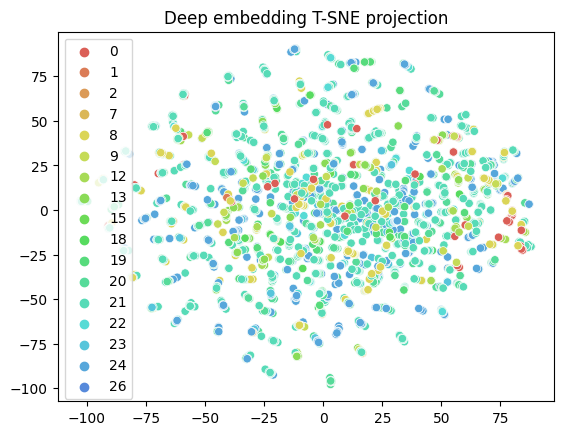

In [60]:
samples = 3100
zdata = 15 * np.random.random(len(emb[:samples]))
# plt.scatter(emb[:samples, 0], emb[:samples, 1])
sns.scatterplot(x=emb[:samples, 0], y=emb[:samples, 1], hue=Y[:samples], 
                palette=sns.color_palette("hls", 27),
                data=emb).set(title="Deep embedding T-SNE projection")

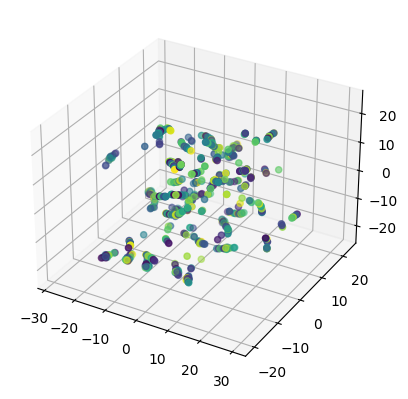

In [58]:
ax = plt.axes(projection='3d')
# fig = plt.figure()
# ax = fig.add_subplot(projection='3d')
samples = 600
zdata = 15 * np.random.random(len(emb[:samples]))
# colors = np.random.randint(255, size=(128, 3))
# for i in range(3):
#     ax.scatter(xs, ys, zs, marker=m)
ax.scatter3D(emb[:samples, 0], emb[:samples, 1], emb[:samples, 2], c=zdata, marker='o')